In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import keras
import keras.applications
import keras.preprocessing.image
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
import tensorflow as tf
import collections
import PIL

import scipy
import sklearn
import sklearn.metrics
from sklearn.pipeline import Pipeline

import math

import sys
import logging 
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 


Using TensorFlow backend.


In [45]:
import general
from general.plotting import gridplot
general.dl.make_keras_picklable()

In [46]:
import simpsons

In [47]:
tf.__version__, keras.__version__, np.__version__

('1.0.0', '1.2.1', '1.12.1')

In [48]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos]

['/cpu:0']

# Some configs

In [49]:
config = dict(
    training_img_shape=(202,360),     # 1/4 of HD image
    test_img_shape=(202,360),         # ...
)

# Load datasets

In [50]:
import gzip
import pickle

with gzip.GzipFile("data/dataset.pickle.zip", "r") as f:
    data = pickle.load(f)

In [51]:
print("train images by char: ", data.train.y.sum(axis=0))
print("train_dev images by char: ", data.train_dev.y.sum(axis=0))
print("dev  images by char: ", data.dev.y.sum(axis=0))
print("test images by char: ", data.test.y.sum(axis=0))
data.show()

train images by char:  [ 91.  79.  64.  37.]
train_dev images by char:  [ 30.  26.  22.  12.]
dev  images by char:  [  74.  101.   66.   65.]
test images by char:  [  73.  102.   64.   64.]
train
  - X: (474, 200, 200, 3)
  - y: (474, 4)
train_dev
  - X: (158, 200, 200, 3)
  - y: (158, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


# Augmenting training set

In [52]:
%store -r background_images
if 'background_images' not in vars(): 
    frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
        background_videoclips_path="data/preprocessing/training/backgrounds",
        background_required_num=100, 
        background_output_shape=config['training_img_shape'],
    )
    background_images = frame_generator.background_images
    %store background_images    
    
    import pickle
    import gzip
    import time

    with gzip.GzipFile("data/background_images.pickle.zip", 'wb') as f:
        pickle.dump(background_images, f)

# Build network

In [53]:
def create_simple_model(num_filters, opt='adam', dropout=0.5):
    model = Sequential()
    model.add(ZeroPadding2D((2,2), input_shape=(None,None,3)))
    model.add(Convolution2D(32,5,5, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(ZeroPadding2D((2,2)))
    model.add(Convolution2D(64,5,5, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(ZeroPadding2D((2,2)))
    model.add(Convolution2D(64,5,5, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(ZeroPadding2D((2,2)))
    model.add(Convolution2D(num_filters, 1,1, activation='relu'))
    model.add(Dropout(dropout, name='dropout'))
    model.add(GlobalMaxPooling2D(name='detectors'))

    model.add(Dense(5, name='output', activation='sigmoid'))
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model
    
    
def create_model(opt='adam', fc_detectors=[], train_all=False, batchnorm=True, dropout=0.5, base_output_layer='block5_pool', num_detectors=16, num_outputs=4):
    if type(base_output_layer) is int:
        base_output_layer = "block{}_pool".format(base_output_layer)

    unknown_img_size_inp = Input(shape=(None,None,3), name='input')
    vgg = keras.applications.vgg16.VGG16(include_top=False)
    base_model = Model(input=vgg.input, output=vgg.get_layer(base_output_layer).output)
    
    base_model_output = x = base_model(unknown_img_size_inp)
    
    if batchnorm:
        x = BatchNormalization(name='bn')(x)
    x = Dropout(dropout, name="dropout")(x)

    for ind, fc_det in enumerate(fc_detectors):
        x = Convolution2D(fc_det, 1, 1, name="fc_detector_{}".format(ind))(x)
    
    x = Convolution2D(num_detectors,1,1, name='detectors_spatial')(x)
    x = GlobalMaxPooling2D(name='detectors')(x)
    
    x = Dense(num_outputs, name='output', activation='sigmoid')(x)
       
    model = Model(input=unknown_img_size_inp, output=x) 
    
    # Compile model    
    if not train_all:
        for l in base_model.layers:
            l.trainable = False
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'accuracy'])
    return model


# Train

Trying to train for a single character only (bart), single model:

In [54]:
# choose characters
chars_chooser = simpsons.preprocessing.CharactersChooser([0,1,2,3])  # bart,homer,lisa,marge
train_X, train_y         = chars_chooser.transform(data.train.X, data.train.y)
train_dev_X, train_dev_y = chars_chooser.transform(data.train_dev.X, data.train_dev.y)
dev_X, dev_y             = chars_chooser.transform(data.dev.X, data.dev.y)


# Create ConstantCVSplitter
all_train_x, all_train_y, cv_splitter = general.utils.ConstantCVSplitter(
    train_X, train_y, train_dev_X, train_dev_y
).split()

# Custom Simpsons scorer
simpsons_scorer = simpsons.scoring.SimpsonsDevsetScorer(dev_X, dev_y)

# Preprocess pipeline
simpsons_preprocess = Pipeline([
        ('vgg_preprocessor', simpsons.preprocessing.VGGPreprocessing()),
    ])

# simpsons frame generator
frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
    preprocess_pipeline=simpsons_preprocess,
    background_images=background_images, 
    background_videoclips_path="data/preprocessing/training/backgrounds",
    background_required_num=100, 
    background_output_shape=config['training_img_shape'],
)


In [193]:
# Run model only and visualize learning curve (loss/epoch)
build_params = [
    {
        'num_outputs': [4], 
        'num_detectors': [128],
        'fc_detectors': [[64]],
    }
]
generator_params = [
    {
        'batch_size': [32],
        'output_shape': [ config['training_img_shape'] ],
        'max_num_characters': [4],
        'train_shape_range': [[0.8,1.0]],        
    }
]

gch = general.dl.DLGridSearch(create_model, build_params=build_params,
                generator_fn=frame_generator.generate, generator_params=generator_params)

gch.fit(data.train.X[:10,:100,:100], data.train.y[:10], train_dev_X[:10,:100,:100], train_dev_y[:10], nb_epoch=5)

INFO:general.dl.dl_grid_search:got 1 generator params options and 1 build params options. overall - 1 options to try
INFO:general.dl.dl_grid_search:fitting model (1/1) with params: {'output_shape': (202, 360), 'fc_detectors': [64], 'train_shape_range': [0.8, 1.0], 'num_outputs': 4, 'max_num_characters': 4, 'num_detectors': 128, 'batch_size': 32}
Epoch 1/5
158s - loss: 0.6318 - mean_absolute_error: 0.7017 - acc: 0.0312 - val_loss: 0.3518 - val_mean_absolute_error: 0.5599 - val_acc: 0.1000
Epoch 2/5
120s - loss: 0.4318 - mean_absolute_error: 0.5054 - acc: 0.1875 - val_loss: 0.3223 - val_mean_absolute_error: 0.5326 - val_acc: 0.1000
Epoch 3/5
101s - loss: 0.3928 - mean_absolute_error: 0.4795 - acc: 0.1562 - val_loss: 0.2935 - val_mean_absolute_error: 0.5033 - val_acc: 0.1000
Epoch 4/5
91s - loss: 0.3383 - mean_absolute_error: 0.4153 - acc: 0.1875 - val_loss: 0.2669 - val_mean_absolute_error: 0.4753 - val_acc: 0.1000
Epoch 5/5
102s - loss: 0.3437 - mean_absolute_error: 0.4292 - acc: 0.1250

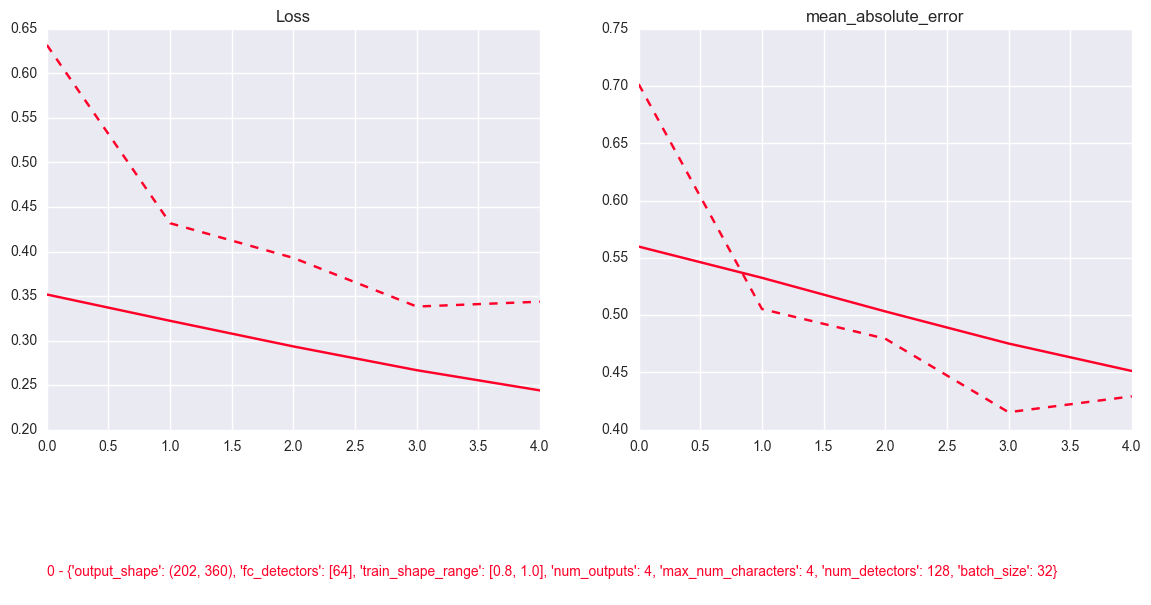

In [194]:
general.plotting.KerasHistoryPlotter().plot(gch.results)

In [261]:
%autoreload
import imp
imp.reload(simpsons.scoring)
simpsons.scoring.SimpsonsReporter(
        train_dev_X[0:40], train_dev_y[0:40], data.dev.X[0:40], data.dev.y[0:40], 
        dev_preprocess=simpsons_preprocess, generator_fn=frame_generator.generate,
        train_dev_num_images=20
).report(gch.results)

In [260]:
sorted([0.5,0.6,0.2,0.9])

[0.2, 0.5, 0.6, 0.9]

In [26]:
simpsons.scoring.SimpsonsReporter(
        train_dev_X, train_dev_y, dev_X, dev_y, 
        dev_preprocess=simpsons_preprocess, generator_fn=frame_generator.generate,
        train_dev_num_images=500
).report(gch.results)

In [243]:
preds = model.predict(data.dev.X[:10])

In [244]:
data.dev.y[:10]

array([[ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]])

In [247]:
dev_y, dev_pred = data.dev.y[:10], preds

In [249]:
max_accs = [
            sorted([ (t, (dev_y[:,char_ind] == (dev_pred[:,char_ind] > t).astype(int)).mean()) for t in np.linspace(0.,1.,21) ], key=lambda x:x[1])[-1][0]
            for char_ind in range(dev_y.shape[1])
        ]
",".join("{:.2f}".format(x) for x in max_accs)

'0.75,0.35,0.90,1.00'

# Show some tagged frames

In [ ]:
dev_sample = data.dev.X[np.random.choice(range(data.dev.X.shape[0]), 20, replace=False)]
model_id = 0
model = gch.results[model_id].history.model
print("params - ", gch.results[model_id].params)

preds = model.predict(simpsons_preprocess.transform(dev_sample))
gridplot(dev_sample, titles=[ ",".join("{:.2f}".format(s) for s in scores) for scores in preds ], num_cols=4)

In [28]:
gch.results[model_id].history.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_17 (Model)                 (None, None, None, 51 14714688    input[0][0]                      
____________________________________________________________________________________________________
bn (BatchNormalization)          (None, None, None, 51 2048        model_17[1][0]                   
____________________________________________________________________________________________________
dropout (Dropout)                (None, None, None, 51 0           bn[0][0]                         
___________________________________________________________________________________________

# Show some generated training images

In [ ]:
%autoreload 
import imp
imp.reload(simpsons.preprocessing)
from general.plotting import gridplot

# Preprocess pipeline
simpsons_preprocess = Pipeline([
        ('vgg_preprocessor', simpsons.preprocessing.VGGPreprocessing()),
        ('vgg_preprocessor_bw', simpsons.preprocessing.VGGPreprocessing(backwards=True)),
        #('blur', simpsons.preprocessing.BlurTransformer(3.0))
    ])


frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
    background_images=background_images, preprocess_pipeline=simpsons_preprocess)

g = frame_generator.generate(data.train.X, data.train.y, max_num_characters=3, batch_size=32,
                             output_shape=config['training_img_shape'], train_shape_range=[0.5,1.0])

gen_imgs, gen_labels = next(g)
gridplot(gen_imgs, titles=gen_labels, num_cols=3)

In [175]:
%autoreload
simpsons.scoring.final_report(data.dev.y[:50], preds_acc)

Char #0 - bart
ACCURACY - 0.940
[[39  0]
 [ 3  8]]
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96        39
        1.0       1.00      0.73      0.84        11

avg / total       0.94      0.94      0.94        50




Char #1 - homer
ACCURACY - 0.840
[[35  2]
 [ 6  7]]
             precision    recall  f1-score   support

        0.0       0.85      0.95      0.90        37
        1.0       0.78      0.54      0.64        13

avg / total       0.83      0.84      0.83        50




Char #2 - lisa
ACCURACY - 0.900
[[41  0]
 [ 5  4]]
             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        41
        1.0       1.00      0.44      0.62         9

avg / total       0.91      0.90      0.88        50




Char #3 - marge
ACCURACY - 0.960
[[42  0]
 [ 2  6]]
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.98        42
        1.0       1.00      0.75 

In [ ]:
# Run pipeline
params = [
    {
        'num_outputs': [4],
        'output_shape': [ (200,200) ],
        'train_shape_range': [[0.25, 0.8], [1.0,1.0]] 
    }
]

model = general.wrappers.KerasClassifier(
    build_fn=create_model, generator_fn=frame_generator.generate,
    nb_epoch=250,
)

gcv = sklearn.model_selection.GridSearchCV(model, params, cv=cv_splitter, scoring=simpsons_scorer)
gcv.fit(all_train_x, all_train_y)

In [ ]:
pd.DataFrame(gcv.cv_results_)

In [11]:
import pickle
import gzip

with gzip.GzipFile("data/gch.pickle.gz", "rb") as f:
    gch = pickle.load(f)
    
# with gzip.GzipFile("data/gch-.pickle.gz", "wb") as f:
#     pickle.dump(gch, f)
    

FileNotFoundError: [Errno 2] No such file or directory: 'data/gch.pickle.gz'

In [5]:
import keras
model = keras.models.load_model("data/model.hdf5")

In [270]:
%autoreload
scls = general.utils.ClassifierThresholdOptimizer(model, simpsons_preprocess.transform(data.dev.X[:100]), data.dev.y[:100])

In [271]:
scls.fit(maximize_fscore=True)

In [59]:
preds

NameError: name 'preds' is not defined

In [10]:
import pickle
pickle.dump(model, open("/tmp/model.pickle", "wb"))

In [4]:
import pickle 
model = pickle.load(open("/tmp/model.pickle", "rb"))

ImportError: No module named 'simpsons.lib.model'

In [4]:
import simpsons

In [5]:
model = simpsons.model.SimpsonsModel(model, [0.5,0.5,0.5,0.5])

In [6]:
video_filename = "data/preprocessing/test/full-episodes/The.Simpsons.S27E18.HDTV.x264-KILLERS[eztv].mkv"
frames = model.analyze_video(video_filename, extractor_params=dict(frames_per_second=2))

In [7]:
idxs = range(1010,1015)
preds = model.predict(frames[idxs])

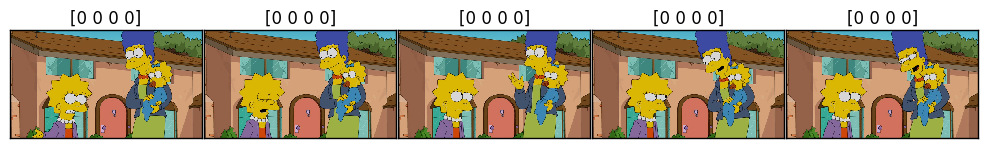

In [9]:
from general.plotting import gridplot
gridplot(frames[idxs], titles=preds.astype(int))

In [90]:
frames.shape

(2555, 404, 720, 3)

In [12]:
preds2 = model2.predict(frames[idxs])

In [13]:
preds

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]], dtype=bool)

In [14]:
preds2

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]], dtype=bool)

# Generating the video - indicators 

In [384]:
import imp
imp.reload(simpsons.video)
#video_filename = "data/preprocessing/test/full-episodes/The.Simpsons.S27E18.HDTV.x264-KILLERS[eztv].mkv"
video_filename = "/tmp/short_video.mp4"

In [385]:
%autoreload 
# Preprocess pipeline
simpsons_preprocess = Pipeline([
        ('vgg_preprocessor', simpsons.preprocessing.VGGPreprocessing()),
    ])


tagger = simpsons.video.SimpsonsVideoTagger(model, [0.25,0.25,0.25,0.25], preprocess_pipeline=simpsons_preprocess)

In [386]:
clip = tagger.tag(video_filename, extractor_params=dict(num_frames=50))

In [387]:
clip.write_videofile("/Users/zach/Desktop/simpsons.mp4", fps=24)

[MoviePy] >>>> Building video /Users/zach/Desktop/simpsons.mp4
[MoviePy] Writing audio in simpsonsTEMP_MPY_wvf_snd.mp3


100%|██████████| 1104/1104 [00:01<00:00, 605.05it/s]

[MoviePy] Done.
[MoviePy] Writing video /Users/zach/Desktop/simpsons.mp4



100%|██████████| 1202/1202 [00:21<00:00, 54.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/zach/Desktop/simpsons.mp4 



In [131]:
c = moviepy.editor.VideoFileClip(video_filename)

In [ ]:
c.subclip(1000,1050).write_videofile("/tmp/short_video.mp4")

# Visualizing training images augmentation

In [68]:
imgs, ys = data.train.X[:32], data.train.y[:32]

In [ ]:
g = frame_generator.generate(data.train.X, data.train.y, output_shape=config['training_img_shape'], train_shape_range=[0.25,0.8])
gen_imgs, gen_labels = next(g)
general.plotting.gridplot(gen_imgs, titles=gen_labels)
print(gen_imgs.shape)

# Train

## Trying to overfit on small samples and scale up
* 1 BG, 10 TRAIN, NO DIST, 25 epochs - overfitted perfectly.
* 1 BG, 50 TRAIN, NO DIST, 25 epochs - overfitted nicely. some positives get mid scores (0.4-0.6)
* 1 BG, ~500 TRAIN, NO DIST, 500 epochs - overfitted. get to loss = ~0.08 with a nice decrease over epochs. Validation stays flat.

__Apparently all above were run with a validation of pure data (not generated = no bg image).__  
__Apparently all above were run with vgg_means in scale of (0,255) and img in scale of (0,1).__

Fixing vgg_means and train_dev_generator:

* 1 BG, 50 TRAIN, NO DIST, 25 epochs - training loss drop to 0 pretty quickly. validation at ~0.05.

Trying with all training images.

* 1 BG, ~500 TRAIN, NO DIST, 25 epochs - train and val drops pretty much together to ~0.01-0.04 (loss). Results on dev are horrible. probably because of the single background image in train.
* ALL BG, ~500 TRAIN, NO DIST, 25 epochs - train and val to ~0.05. no overfitting. performs a bit better on dev but still sucks..

Adding more backgrounds (~100 now). Cleaning training images. Training images are now 100x200.  
Adding distortions back:

* ALL BG, ALL TRAIN, WITH DISTS, 40 epochs - no overfitting. train and train_dev together to ~0.05 (loss). validation looks nice. misses some (mostly when bart's hair is not in the image). might be because it was only trained for 40 epochs and didn't see a lot of distortions.

## Testing hyperparameters

1. what level to hook into? __clearly 5__
1. with/without first batchnorm (right after VGG)? __with__
1. dropout ratio (with first batchnorm) - __0.1, 0.25 and 0.5 are acceptable__
1. with/without second batchnorm (after detectors, before last FC) and dropout ratios - __without second batchnorm, 0 and 0.25 are fine__
1. trainall vs. traindelta? __clearly traindelta__


## Comparing performances on train_dev and dev

All settings are: ALL BG, ALL TRAIN, WITH DISTS, train_all=False, base_output_layer=5, batchnorm=True, dropout=0.25

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| default | loss ~0.05, no overfitting. AUC=0.94, 80%r=70%p | AUC=0.67, 80%r=10%p | maybe overfitting the train_dev. trying to increase dropout. |
| try with more zoom (0.9,2.5), 500 epochs, droprout=0.5 | noisy. loss ~0.08. AUC=0.65, 80%r=15%p | AUC=0.62, 80%r=5%p | looked at bart imgs in train_dev and dev and sorted by score. small barts get low score. large barts are identified easily. should try to train on 100x100 and move the patch on the frame |
| no shift_range, rotation=10.0, more zoom (1.0, 3.5), 500 epochs, dropout=0.5 | flat after epoch 200, loss ~0.13. AUC=0.82, 80%r=0%p|  AUC=0.65, 80%r=2%p| |

Changing training images back to 100x100. trying to get perfect fit on train_dev

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| train 100x100, zoom 1.0-1.5, no other dists, 50 epochs | loss ~0.08, AUC=0.87, 80%r=75%p | AUC=0.66 , 80%r=5%p | |

Changing training images - removing scaling to 100x100. every image is centered in black background of 100x100 but unscaled

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| train 100x100, zoom 1.0-1.5, no other dists, 50 epochs | AUC=0.95 , 80%r=70%p | AUC=0.61  , 80%r=0%p |  |

Train images are 100x100. Changing dev images to 202x360 (50% of orig).

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| no dists, 100 epochs | AUC=1.00 , 80%r=100%p | AUC=0.69 , 80%r=40%p | By looking at dev, I believe the main problem is the black edge on training images  |
| changed train gen to reduce black edge. 50 epochs | AUC=0.74 , 80%r=30%p | AUC=0.82 , 80%r=40%p | |
| \*same\*.  training 50 epochs more. __Also calculating train_dev stats on many iterations__ | AUC=0.96 , 80%r=90%p | AUC=0.81 , 80%r=45%p | |
| \*same\*.  training 100 epochs more. | AUC=0.96 , 80%r=90%p | AUC=0.78 , 80%r=50%p | looks much better when examining dev. should try to add more dists and check if it's better to predict on the whole dev image or slide across it |
| adding dists: rotate 10.0, zoom: [0.9,1.5]. comparing dropout=0,25, 0.5. 100 epochs | | | | 
| \* _dropout=0.25_ | AUC=0.94, 80%r=80%p | full: AUC=0.77, 80%r=50%p. patches: AUC=0.8, 80%r=50%p | |
| \* _dropout=0.5_ | AUC=0.92, 80%r=70%p | full: AUC=0.77, 80%r=50%p. patches: AUC=0.81, 80%r=40%p | | 
| 100 epochs more (dropout=0.25) | AUC=0.92, 80%r=70%p | full: AUC=0.77, 80%r=35%p. patches: AUC=0.79, 80%r=55%p | | |
| 500 epochs more (dropout=0.25) | AUC=0.97, 80%r=80%p | full: AUC=0.75, 80%r=45%p. patches: AUC=0.78, 80%r=30%p | | |

## Adding marge

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| 200 epochs | 0.97, 0.94 | 80%, 75% | 0.73, 0.86 | 35%, 50% | should try with more detectors |
| tried with 32,64,128 detetors. lost the data. keep with 32 detectors ||||||
| > Focusing on making train closer to dev. Mainly by image manipulation. I believe a better training images generation and a better patch_img_on_background process will get significant results. <br/><br/> changing training image rescaling method to __'lanczos'__ (looks better with the characters edges). Also removed all dists. 100 epochs | 0.98, 0.96 | 85%, 95% | 0.67, 0.84 | 30%, 40% | |
| changed black sensitivity in patch_img_on_background (0.3 -> 0.1). 100 epochs | 0.95, 0.9 | 85%, 80%| 0.67, 0.86 | 20%, 40% | | 
| adding dists back: (100 epochs) | | | | | |
| + zoom [0.9, 1.2] | 0.96, 0.98 | 85%, 90% | 0.64, 0.82 | 85%, 40% | * 85%?? reading error? |
| + rotation 10.0 | 0.98, 0.98 | 80%, 85% | 0.64, 0.74 | 25%, 20% | should remove rotation. it makes images grainy on the edges. Also - scale 0.8 looks a bit better |
| removing rotation. zoom only [0.9, 1.5] | 0.94, 0.92 | 80%, 80% | 0.66, 0.78 | 15%, 35% | scaled dev (0.7) brings results to 0.70, 0.81, 15%, 50% |
| training 100 epochs more (200 total) | 0.97, 0.94 | 85%, 65% | 0.69, 0.83 | 20%, 50% | |
| no dists, 200 epochs | 0.99, 1.00 | 95%, 95% | 0.67, 0.74 | 20%, 30% | scaled (0.7) brings marge to 0.84 and 50%. In general, scale 0.7 seems optimal for AUC in both characters | 

Increasing training size to (150,150). Still bart and marge only

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| no dists, 100 epochs | 0.99, 0.97 | 95%, 90% | 0.69, 0.90 | 30%, 70%| |
| with zoom [1.0, 1.5], 100 epochs | 0.98, 0.96 | 90%, 80% | 0.69, 0.87 | 30%, 55% | |
| no dists. 200 epochs | 0.97, 0.96 | 90%, 90% | 0.70, 0.85 | 35%, 65% | |
| AUC/epoch analysis shows that there is no increasing of AUC after 100 epochs. | | | | | should try on all characters |
| Added blur to patch_img_on_background. no dists. 100 epochs | 1.00, 1.00 | 100%, 95% | 0.74, 0.86 | 40%, 60% | |


Keeping the blur on training images.  

## All characters

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| no dists, 100 epochs. 16 detectors | ~1.00 | ~90% | 0.65,0.86,0.66,0.38,0.76 | 35%,55%,5%,0%,20%| |
| no dists, 100 epochs. 32 detectors | ~1.00 | ~90%-95% | 0.68,0.79,0.64,0.38,0.82 | 30%,20%,5%,0%,50% | |
| no dists, 100 epochs. 48 detectors | ~0.98 | ~90%-100% | 0.65,0.82,0.65,0.54,0.86 | 20%,20%,15%,0%,50%| |
| no dists, 100 epochs. 64 detectors | ~1.00 | ~90%-100% | 0.65,0.85,0.64,0.46,0.85 | 15%,40%,10%,0%,60%| |

Observations: 
* detectors num - keep it 48 for now. not much of a difference
* number of epochs - helps only marge.
* severe problem with maggie. 
* maggie gets better results on zoom > 1.5 (others - not significant impact)
* a lot of misses on small characters (weird with the previous bullet)
* maybe should measure "maximal acceptance precision" as a lot of the images that contain a character, contains it poorly.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| adding zoom [1.0, 2.0], 100 epochs (48 detectors) | ~0.95 | ~70%-90% | 0.72,0.74,0.63,0.42,0.78 | 15%,5%,5%,0%,35% | |
| no dists. fc_detectors=[64]. 100 epochs | ~1.00 | ~90% | 0.66,0.79,0.66,0.54,0.84 | 30%,30%,10%,0%,50% | |
| no dists. fc_detectors=[64,64]. 50 epochs | ~1.00 | ~90%-100% | 0.63,0.8,0.59,0.35,0.85 | 20%,10%,20%,0%,55% | |


## Zero-score dev pics analysis

| Character | # pics in dev | # should find | % should find | % > 0.5 | # super hard | % super hard | comments | 
| --- |
| Bart | 38 | 25 | 65% | 34% | 11 | 29% | Some super-hards with baseball cap on. In some, Bart is very small (50x70). In some - turning his back |
| Homer | 48 | 41 | 85% | 40% | 4 | 8% | Missing some where Homer is small (opening frames) but in some he is very large in the frame |
| Lisa | 40 | 20 | 50% | 15% | 8 | 20% | A lot of small Lisa's |
| Maggie | 14 | 8 | 57% | 0% | 3 | 21% | All get 0.0. Single one gets 0.08. Maggie is very small in almost all pics (~70x70). |
| Marge | 48 | 38 |80% | 33% | 10 | 20% | Turning her back. few too large, few too little |

Conclusions: 
* Should work on "multi-size" model.
* Check why adding parts to an image (taking larger areas) reduces (sometimes dramatically) the score
  * Try to remove BatchNorm. It changes detectors outputs when overall image is changing..

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| trying without batchnorm. 100 epochs | ~0.98 | ~90%-100%| 0.71,0.84,0.62,0.56,0.83| 20%,15%,20%,10%,40%| |  
| trying a "small model" vs a "large model" | | | | | |
| * small model - all training imgs with zoom=2.0 | 0.89,0.87,0.86,0.85,0.96 | 15%-70% | 0.70,0.73,0.59,0.48,0.74 | 10%-40% | |
| * large model - all training imgs with zoom=1.0 | 0.99,0.99,0.98,1.00,0.97 | 50%-100% | 0.67,0.83,0.60,0.62,0.87 | 10%-50% | | 

Changing the train generator:   
* Using rescale to create smaller images
* Cropping empty borders so character fills the entire image in all sizes

Adding a "combined PR curve" that measures recall when setting both large and small models on the same precision.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| No dists. small=(100,100) | 1.00,0.99,1.00,1.00,1.00 | 95%-100% | 0.60,0.81,0.61,0.59,0.77 | 10%-50% | |
| No dists. large=(150,150) | 1.00,1.00,1.00,1.00,0.97 | 90%-100% | 0.61,0.87,0.63,0.63,0.84 | 10%-65% | |
| Combined | | | | 15%-65% | |
| | | | | | |
| *Changing dropout to 0.2*, Adding dists: 5.0 rotation, 0.05 shift, 0.1 zoom. Trying various sizes of training images | | | | | | 
| tiny (50,50) | 0.95,0.92,0.93,0.97,0.90 | 50%-70% |      0.63,0.48,0.56,0.59,0.61 | 10%-35% | |
| v.small (75,75) | 1.00,0.99,0.99,1.00,0.99 | 85%-100% |  0.63,0.80,0.63,0.61,0.60 | 10%-50% | |
| small (100,100) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.59,0.76,0.64,0.59,0.75 | 10%-45% | |
| large (150,150) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.62,0.89,0.66,0.57,0.82 | 10%-75% | |
| v.large (200,200) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.61,0.92,0.64,0.56,0.78 | 10%-75% | |


### New test set - 700 frames from 100 episodes.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (100,100) | 0.98,0.96,0.99,1.00,0.98 | 60%-100% | 0.66,0.65,0.67,0.44,0.75 | 5%-35% | |
| large | 1.00,0.99,1.00,1.00,1.00 | 100%-100% | 0.68,0.78,0.72,0.47,0.83 | 5%-45% | |
| trying different # dets | 
| 32 dets | 0.99,0.98,0.99,0.97,0.94 | 60%-100% |  0.71,0.79,0.67,0.43,0.83 | 5%-45% | | 
| 64 dets | 0.99,0.99,0.99,0.99,0.96 | 65%-100% |  0.72,0.81,0.68,0.41,0.83 | 5%-50% | |
| 128 dets | 0.99,0.99,0.99,0.98,0.99 | 70%-100% | 0.71,0.81,0.69,0.41,0.84 | 5%-55% | |
| 256 dets | 0.54,1.00,0.99,1.00,0.96 | 20%-100% | 0.45,0.77,0.72,0.42,0.81 | 5%-45% | weird.. got stuck on characters multiple times |
| 512 dets | 0.99,1.00,0.99,0.75,0.96 | 15%-100% | 0.72,0.78,0.71,0.43,0.83 | 5%-45% | |
| 1024 dets | 0.99,1.00,0.99,0.75,0.59 | 5%-100% | 0.69,0.79,0.71,0.47,0.36 | 5%-45% | |
| 2048 dets | 1.00,1.00,0.98,0.78,0.45 | 5%-100% | 0.73,0.81,0.68,0.43,0.33 | 5%-50% | |
| 128 dets, different dropouts | 
| 128 dets, dropout=0.5 | 1.00,1.00,0.99,1.00,1.00 | 100%-100% | 0.72,0.78,0.75,0.43,0.79 | 5%-45% | |
| 128 dets, dropout=0.2 | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.75,0.80,0.72,0.40,0.79 | 5%-50% | |
| 128 dets, dropout=0.2, different num_epochs | 
| 10 epochs | 0.55,0.93,0.95,0.94,0.74 | 10%-75% |    0.43,0.79,0.62,0.42,0.54 | 5%-45% | |
| 20 epochs | 0.51,0.98,0.98,0.96,0.95 | 20%-100% |   0.43,0.80,0.67,0.37,0.73 | 5%-45% | |
| 30 epochs | 0.88,0.98,0.99,0.98,0.95 | 25%-100% |   0.64,0.80,0.66,0.37,0.82 | 5%-50% | |
| 40 epochs | 0.99,0.99,0.99,1.00,0.96 | 70%-100% |   0.74,0.78,0.70,0.41,0.81 | 5%-45% | |
| 50 epochs | 0.99,0.99,1.00,1.00,0.96 | 85%-100% |   0.74,0.79,0.66,0.38,0.81 | 5%-45% | |
| 50 epochs | 1.00,1.00,0.99,0.99,0.98 | 80%-100% |   0.74,0.77,0.69,0.41,0.83 | 5%-45% | |
| 60 epochs | 0.99,1.00,0.99,1.00,1.00 | 95%-100% |   0.74,0.79,0.67,0.40,0.81 | 5%-45% | |
| 100 epochs | 1.00,1.00,0.99,1.00,0.99 | 100%-100% | 0.73,0.75,0.71,0.47,0.82 | 5%-45% | |
| 150 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.78,0.73,0.44,0.80 | 5%-45% | |
| 200 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.72,0.78,0.72,0.44,0.80 | 5%-45% | |
| 250 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.75,0.41,0.82 | 5%-45% | |
| 300 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.70,0.77,0.75,0.40,0.80 | 5%-45% | |
| 350 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.75,0.40,0.81 | 5%-45% | |
| 400 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.74,0.40,0.80 | 5%-45% | |
| 450 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.70,0.77,0.74,0.39,0.81 | 5%-40% | |
| 500 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.72,0.78,0.76,0.39,0.83 | 5%-45% | |
| 550 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.74,0.78,0.74,0.38,0.80 | 5%-40% | |
| 600 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.74,0.78,0.75,0.37,0.80 | 5%-45% | |

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (75,75), 60 epochs |   0.98,0.98,0.98,0.98,0.90 | 25%-95% |  0.71,0.65,0.61,0.36,0.64 | 5%-40% | |
| large (200,200), 60 epochs | 1.00,1.00,0.98,0.97,0.97 | 55%-100% | 0.73,0.80,0.70,0.44,0.82 | 5%-50% | |
| combined | 

Regenerating training images to be (200,200). completely ignoring images that are less than (200,200) (in both dimentions).  
** Also: removing maggie **  
** adding stratified splitting of train/test sets**

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (75,75), 200 epochs |   1.00,0.97,1.00,0.99 | 90%-100% |  0.73,0.67,0.63,0.71 | 25%-35% | |
| large (200,200), 200 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.76,0.72,0.72,0.81 | 30%-40% | |
| combined | | | | 30.0,40.0,25.0,35.0 |
| |
| Adding zoom 0.5-1.5 to both large and small |
| small (75,75), 100 epochs | 0.93,0.92,0.96,0.96 | 55%-85% | 0.71,0.57,0.59,0.68 | 20%-30% |
| large (200,200), 100 epochs | 0.99,0.99,0.99,0.99 | 70%-100% | 0.76,0.76,0.69,0.83 | 25%-45% |
| combined, 100 epochs | | | | 30.0,40.0,20.0,35.0 |
| small (75,75), 250 epochs | 0.98,0.94,0.95,0.99 | 70%-90% | 0.72,0.63,0.64,0.73 | 25%-35% | |
| large (200,200), 250 epochs | 1.00,0.99,1.00,1.00 | 95%-100% | 0.74,0.76,0.69,0.79 | 25%-45% | |
| combined, 250 epochs | | | | 30.0,45.0,25.0,35.0 |
| |
| Training image is now at size of background with the character placed randomaly inside. Adding zoom [1.0,2.0], trying a single model | |
| 100 epochs | 0.98,0.99,0.99,1.00 | 95%-100% |  0.82,0.75,0.71,0.82 | 25%-45% | |
| 200 epochs | 1.00,0.98,1.00,1.00 | 95%-100% |  0.80,0.75,0.72,0.82 | 25%-40% | |
| 300 epochs | 1.00,0.98,0.99,1.00 | 95%-100% |  0.81,0.73,0.72,0.82 | 25%-40% | |
| 400 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.78,0.75,0.73,0.82 | 25%-40% | |
| | 
| Trying large and small, 100 epochs |
| small - output_shape=(100,100) | 0.92,0.89,0.95,0.97 | 50%-80% |   0.72,0.63,0.67,0.77 | 25%-35% |
| large - output_shape=None (bg) | 1.00,1.00,1.00,0.93 | 100%-100% | 0.72,0.72,0.71,0.73 | 25%-40% |
| combined | | | | 35.0,40.0,25.0,30.0 |
| |
| Changing zoom mechanism to change the size of the whole training image, thus making it "moving" on the background. |
| single model - output_shape=None, train_shape_range=[0.3,1.0], 200 epochs | 0.99,0.99,1.00,0.99 | 95%-100% | 0.78,0.75,0.73,0.82 | 25%-40% | |
| small - output_shape=(100,100), train_shape_range=[0.6,1.0], 200 epochs | 0.98,0.97,0.96,0.99 | 75%-90% | 0.71,0.64,0.70,0.61 | 25%-35% |  |
| large - output_shape=None, train_shape_range=[0.6,1.0], 200 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.73,0.70,0.72,0.79 | 25%-35% | |
| small+large | | | | 35.0,35.0,25.0,30.0 |


# Look at model predictions

In [ ]:
idxs = np.random.permutation(range(data.dev.X.shape[0]))[:]
imgs = data.dev.X[idxs]
labels = data.dev.y[idxs]
preds = model.predict(imgs-VGG_MEANS)
labels_str = np.apply_along_axis(lambda x: ",".join(str(int(i)) for i in x), arr=labels, axis=1)
preds_str = np.apply_along_axis(lambda x: ",".join("{:.2f}".format(i) for i in x), arr=preds, axis=1)

misses = (labels[:,0]==1)&(preds.flatten()<0.5)

titles = np.array([str(a)+"\n"+str(b) for a,b in zip(labels_str, preds_str)])
gridplot(imgs[misses], titles=titles[misses], num_cols=4)


In [ ]:
#idxs = np.random.permutation(range(data.dev.X.shape[0]))[:30]
imgs, true_labels = next(train_generator)
#true_labels = np.apply_along_axis(lambda x: ",".join(str(int(i)) for i in x), arr=data.dev.y[idxs], axis=1)
preds = model.predict(imgs)
preds_str = np.apply_along_axis(lambda x: ",".join("{:.2f}".format(i) for i in x), arr=preds, axis=1)

titles = [ str(a)+"\n"+str(b) for a,b in zip(true_labels, preds_str)]
gridplot(imgs+VGG_MEANS, titles=titles, num_cols=4)


# Measure "acceptable" recall rates per character

In [46]:
num_images_per_char = 50
dev_with_chars = [ 
    np.random.permutation(np.argwhere(data.dev.y[:,char_id] == 1).flatten())[:num_images_per_char]
    for char_id in range(data.dev.y.shape[1])
]

In [47]:
num_acceptable_misses = np.array([ 9, 7, 4, 7])
EXPECTED_RECALL = (1 - num_acceptable_misses / num_images_per_char)
EXPECTED_RECALL


array([ 0.82,  0.86,  0.92,  0.86])

In [ ]:
gridplot(data.dev.X[dev_with_chars[3]], num_cols=4)

In [ ]:
img_id = 10
img = data.dev.X[img_id]
plt.imshow(img)

In [20]:
print("large - ", model_large.predict(data.dev.X[img_id:img_id+1]))
print("small - ", model_small.predict(data.dev.X[img_id:img_id+1]))

large -  [[ 0.04223018  0.0010492   0.01006061  0.01534708  0.02023211]]
small -  [[ 0.01124375  0.02011814  0.0013459   0.00053619  0.01275119]]


In [21]:
print("large - ", model_large.predict(data.dev.X[img_id:img_id+1,50:200,0:150]))
print("small - ", model_small.predict(data.dev.X[img_id:img_id+1,50:200,0:150]))

large -  [[ 0.05349551  0.05320396  0.66861141  0.36786184  0.06011999]]
small -  [[ 0.02708604  0.1634855   0.164868    0.06872728  0.06635981]]


In [22]:
print("large - ", model_large.predict(data.dev.X[img_id:img_id+1,50:150,50:150]))
print("small - ", model_small.predict(data.dev.X[img_id:img_id+1,50:150,50:150]))

large -  [[ 0.08062574  0.0233823   0.61664689  0.55255646  0.0492446 ]]
small -  [[ 0.03419701  0.20877671  0.19787765  0.06697661  0.03950718]]


In [ ]:
gen_imgs, gen_labels = next(train_generator_small)

i = np.zeros((100,200,3))
i[:100,:100,:] = data.dev.X[img_id,50:150,50:150,:]
i[:100,100:200,:] = gen_imgs[gen_labels[:,2]==1][0] + VGG_MEANS

plt.imshow(i)

In [ ]:
img_slice = img[50:200,0:150,:]
plt.imshow(img)

In [30]:
model_large.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_15 (Model)                 (None, None, None, 51 14714688    input[0][0]                      
____________________________________________________________________________________________________
dropout (Dropout)                (None, None, None, 51 0           model_15[1][0]                   
____________________________________________________________________________________________________
detectors_spatial (Convolution2D (None, None, None, 48 24624       dropout[0][0]                    
___________________________________________________________________________________________

In [45]:
# find the top 5 detectors for lisa
top_5_lisa_dets = model_large.get_layer('output').get_weights()[0][:,2].argsort()[:5]

In [33]:
f = K.function([model_large.input, K.learning_phase()],[model_large.get_layer('detectors').output])

In [34]:
print(model_large.predict(img[None,:]))
dets_img = f([img[None,:], False])[0]

[[ 0.04223018  0.0010492   0.01006061  0.01534708  0.02023211]]


In [35]:
print(model_large.predict(img_slice[None,:]))
dets_img_slice = f([img_slice[None,:], False])[0]

[[ 0.05349551  0.05320396  0.66861141  0.36786184  0.06011999]]


In [ ]:
plt.plot(dets_img[0], label='img')
plt.plot(dets_img_slice[0], label='img_slice')
plt.legend(loc='best')

for i,x in enumerate(top_5_lisa_dets):
    plt.axvline(x, color=plt.cm.gray(0.1*i), linestyle='--')

In [61]:
act_map_keras = K.function([model_large.input, K.learning_phase()], [model_large.get_layer('detectors_spatial').output])
def act_map(inp, det_id):
    return act_map_keras([img[None,:], False])[0][:,:,:,det_id]

In [ ]:
def show_img_det(img, det_id):
    extent = 0, img.shape[1], 0, img.shape[0]
    plt.imshow(img, alpha=1., extent=extent)
    plt.imshow(act_map(img[None,:], det_id)[0], cmap=plt.cm.jet, alpha=0.25, extent=extent, interpolation='nearest')
    
plt.figure(figsize=(10,5))
plt.subplot(121)
show_img_det(img, top_5_lisa_dets[2])
plt.subplot(122)
show_img_det(img_slice, top_5_lisa_dets[2])

# Understanding why "detectors" don't output the same for different sizes

In [244]:
model=model_large
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_15 (Model)                 (None, None, None, 51 14714688    input[0][0]                      
____________________________________________________________________________________________________
dropout (Dropout)                (None, None, None, 51 0           model_15[1][0]                   
____________________________________________________________________________________________________
detectors_spatial (Convolution2D (None, None, None, 48 24624       dropout[0][0]                    
___________________________________________________________________________________________

In [245]:
detectors_act = K.function([model.input, K.learning_phase()], [model.get_layer('detectors_spatial').output])

In [249]:
import matplotlib.gridspec
img = data.dev.X[img_id]
extent = 0, img.shape[1], 0, img.shape[0]

img_slice = img[50:200,0:150]
extent_slice = 0, img_slice.shape[1], 0, img_slice.shape[0]

img_pred = model.predict(img[None,:]-VGG_MEANS)
img_slice_pred = model.predict(img_slice[None,:]-VGG_MEANS)

dets = detectors_act([img[None,:], False])[0]
dets_slice = detectors_act([img_slice[None,:], False])[0]

In [ ]:
def get_top_value_rectangle_params(det_scores, img):
    top_value_ind = np.unravel_index(det_scores.argmax(), det_scores.shape)
    img_box_size = np.array(img.shape[:2]) / det_scores.shape
    bl_corner = ((top_value_ind + np.array((1,0))) * img_box_size)
    xy = (bl_corner[1], img.shape[0] - bl_corner[0])
    return xy, img_box_size[1], img_box_size[0]

f = plt.figure(figsize=(20,60))
sns.set_style('white')
gs = gridspec.GridSpec(12,4)
for det_id in range(dets.shape[-1]):
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[det_id])

    ax = plt.Subplot(f, gs0[0])
    ax.imshow(img, alpha=0.5, extent=extent)
    ax.imshow(dets[0,:,:,det_id], alpha=0.5, extent=extent, vmin=-5., vmax=5., cmap=plt.cm.jet, interpolation='nearest')
    ax.axis('off')
    ax.set_title("det {}".format(det_id))
    ax.add_patch(matplotlib.patches.Rectangle( *get_top_value_rectangle_params(dets[0,:,:,det_id], img), lw=2, ec='green', fill=False, alpha=1.0 ))

    f.add_subplot(ax)
    
    
    ax = plt.Subplot(f, gs0[1])
    ax.imshow(img_slice, alpha=0.5, extent=extent_slice)
    ax.imshow(dets_slice[0,:,:,det_id], alpha=0.5, extent=extent_slice, vmin=-5., vmax=5., cmap=plt.cm.jet, interpolation='nearest')
    ax.axis('off')
    ax.add_patch(matplotlib.patches.Rectangle( *get_top_value_rectangle_params(dets_slice[0,:,:,det_id], img_slice), lw=2, ec='green', fill=False, alpha=1.0 ))
    f.add_subplot(ax)

In [ ]:
sns.set_style('whitegrid')
plt.plot(dets.max(axis=(0,1,2)), label='image')
plt.plot(dets_slice.max(axis=(0,1,2)), label='image_slice')
plt.legend()

# Find detectors for a specific character

In [44]:
char_id = 3
char_imgs = data.dev.X[data.dev.y[:,char_id] == 1]
#char_pred = model.predict(char_imgs)

char_dets = detectors_act([char_imgs, False])[0].max(axis=(1,2))

dets_mean = char_dets.mean(axis=0)
dets_std = char_dets.std(axis=0)


In [ ]:
plt.errorbar(range(dets_mean.shape[0]), dets_mean, yerr=dets_std, ecolor='lightblue')

# AUC by epochs

In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)
model = create_model(base_output_layer=5, train_all=False, batchnorm=True, dropout=0.5, num_detectors=32)

epochs_per_iter = 5
num_iters = 20
epochs = []
aucs = []
num_epochs = 0
for i in range(num_iters):
    print("num_epochs - ", num_epochs)
    model.fit_generator(train_generator, validation_data=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0],
                            samples_per_epoch=len(data.train.X), nb_epoch=epochs_per_iter, verbose=0)
    
    num_epochs += epochs_per_iter
    epochs.append(num_epochs)
    aucs.append(aucs_for_scaled_dev(model, data.dev.X, data.dev.y, data.dev.X.shape[1:3]))


In [ ]:
plt.plot(epochs, aucs)
plt.ylim(0,1)
plt.legend()

# Comparing train/dev images

In [ ]:
import random
import PIL

class MYSMOOTH(PIL.ImageFilter.BuiltinFilter):
    name = "Smooth"
    filterargs = (3, 3), 15, 0, (
        1,  1,  1,
        1,  7,  1,
        1,  1,  1
        )

num_imgs, spacing = 8, 5
scale_factor = 0.8
train_imgs, _ = next(random_background_generator(data.train.X, data.train.y, bg_imgs))
train_img_shape = train_imgs.shape[1:]

comp_imgs = np.zeros((num_imgs*(train_img_shape[0]+spacing) ,4*(train_img_shape[1]+spacing), train_img_shape[2]))
for i in range(num_imgs):
#    dev_scaled = scipy.misc.imresize(data.dev.X[i], (int(scale_factor*data.dev.X.shape[1]),int(scale_factor*data.dev.X.shape[2])))/255.
    r_h = random.randint(0,data.dev.X.shape[1]-train_img_shape[0])
    r_w = random.randint(0,data.dev.X.shape[2]-train_img_shape[1])

    i1 = PIL.Image.fromarray(((train_imgs[i]+VGG_MEANS)*255.).astype('uint8'))
    i1 = i1.filter(PIL.ImageFilter.SMOOTH)
    i1_arr = np.array(i1)/255.

#     i2 = PIL.Image.fromarray(((train_imgs[i]+VGG_MEANS)*255.).astype('uint8'))
#     i2 = i2.filter(MYSMOOTH)
#     i2_arr = np.array(i2)/255.

    comp_imgs[i*(train_img_shape[0]+spacing):i*(train_img_shape[0]+spacing)+train_img_shape[0], 0*(train_img_shape[1]+spacing):0*(train_img_shape[1]+spacing)+train_img_shape[1], :] = \
        train_imgs[i] + VGG_MEANS
    comp_imgs[i*(train_img_shape[0]+spacing):i*(train_img_shape[0]+spacing)+train_img_shape[0], 1*(train_img_shape[1]+spacing):1*(train_img_shape[1]+spacing)+train_img_shape[1], :] = \
        data.dev.X[i, r_h:r_h+train_img_shape[0], r_w:r_w+train_img_shape[1], :]
    comp_imgs[i*(train_img_shape[0]+spacing):i*(train_img_shape[0]+spacing)+train_img_shape[0], 2*(train_img_shape[1]+spacing):2*(train_img_shape[1]+spacing)+train_img_shape[1], :] = \
        i1_arr
#     comp_imgs[i*(train_img_shape[0]+spacing):i*(train_img_shape[0]+spacing)+train_img_shape[0], 3*(train_img_shape[1]+spacing):3*(train_img_shape[1]+spacing)+train_img_shape[1], :] = \
#         i2_arr

sns.set_style('white')
plt.figure(figsize=(12, 12*num_imgs))
plt.imshow(comp_imgs)
plt.axis('off')

# Dev images sorted by selected character's score

In [13]:
dev_pred = model.predict(data.dev.X-VGG_MEANS)

In [16]:
dev_scaled = scale_imgs(data.dev.X, (data.dev.X.shape[1]*2, data.dev.X.shape[2]*2))
dev_scaled_pred = np.zeros_like(data.dev.y)
#dev_scaled_pred = model.predict(dev_scaled-VGG_MEANS)
#dev_scaled_pred1 = model.predict(dev_scaled[:50]-VGG_MEANS)
#dev_scaled_pred2 = model.predict(dev_scaled[50:100]-VGG_MEANS)
#dev_scaled_pred3 = model.predict(dev_scaled[100:150]-VGG_MEANS)
#dev_scaled_pred4 = model.predict(dev_scaled[150:200]-VGG_MEANS)


In [ ]:
char_id = 2

char_imgs, char_scores, char_scaled_scores = data.dev.X[data.dev.y[:,char_id]==1], dev_pred[data.dev.y[:,char_id]==1][:,char_id], dev_scaled_pred[data.dev.y[:,char_id]==1][:,char_id]
sorted_ind = char_scores.argsort()
gridplot(char_imgs[sorted_ind], titles=[ "{:.2f} {:.2f}".format(a,b) for (a,b) in zip(char_scores[sorted_ind], char_scaled_scores[sorted_ind]) ])


In [ ]:
img = dev_scaled[data.dev.y[:,char_id]==1][sorted_ind][0]
img_slice = img[200:400,0:700]
print([ "{:.3f}".format(s) for s in model.predict(img[None,:])[0] ])
print([ "{:.3f}".format(s) for s in model.predict(img_slice[None,:])[0] ])
plt.imshow(img_slice)

In [ ]:
plt.imshow(char_imgs[sorted_ind][2])

# Checking multiple scale levels of dev

In [ ]:
def aucs_for_scaled_dev(model, X, y_true, scaled_shape):
    scaled_imgs = scale_imgs(X, scaled_shape)
    y_pred = model.predict(scaled_imgs)
    n_chars = y_pred.shape[1]
    
    aucs = [ sklearn.metrics.roc_auc_score(y_true[:,ind], y_pred[:,ind]) for ind in range(n_chars) ]
    return aucs

scales = np.linspace(0.25,2.0,10)
aucs = []
for s in scales:
    shape = (int(202*s),int(360*s))
    aucs.append(aucs_for_scaled_dev(model, data.dev.X, data.dev.y, shape))

plt.plot(scales, aucs)


---
# Hyper parameters

# Test what conv level to hook into

In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)

models = collections.OrderedDict([
        (l, create_model(base_output_layer=l, train_all=False, batchnorm=False))
        for l in range(1,6)
    ])
conv_layer_hists = train_for_all_models(models, nb_epoch=40,
                             train_generator=train_generator, train_dev_generator=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0])

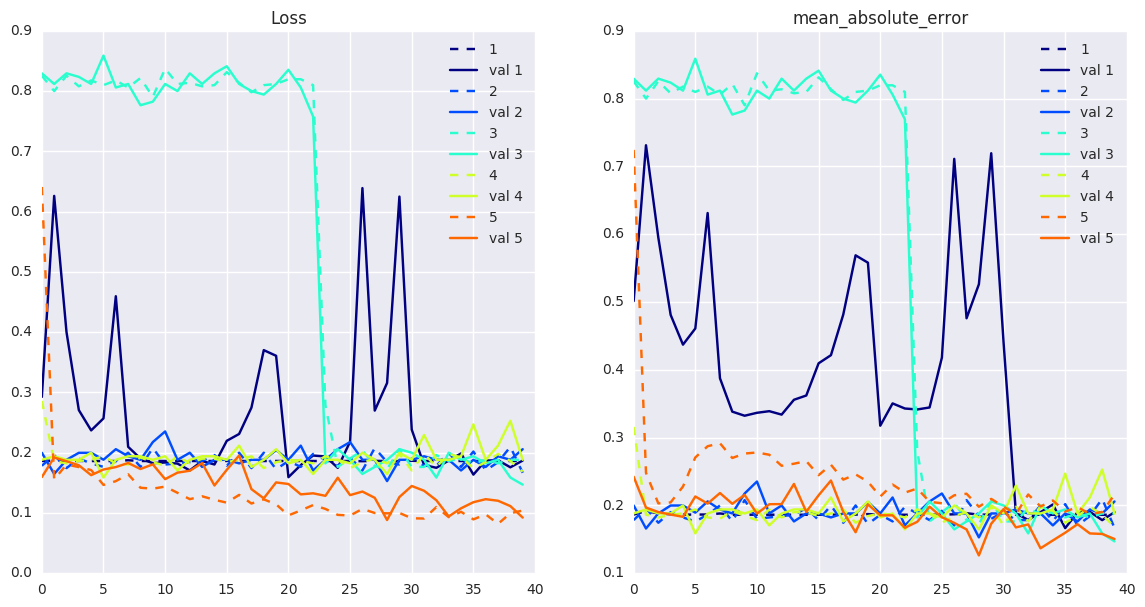

In [ ]:
plot_hists(conv_layer_hists)

# Batchnorm - with/without

In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)

models = collections.OrderedDict([
        ('batchnorm', create_model(base_output_layer=4, train_all=False, batchnorm=True)),
        ('no batchnorm', create_model(base_output_layer=4, train_all=False, batchnorm=False)),
    ])
bn_hists = train_for_all_models(models, nb_epoch=40,
                             train_generator=train_generator, train_dev_generator=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0])

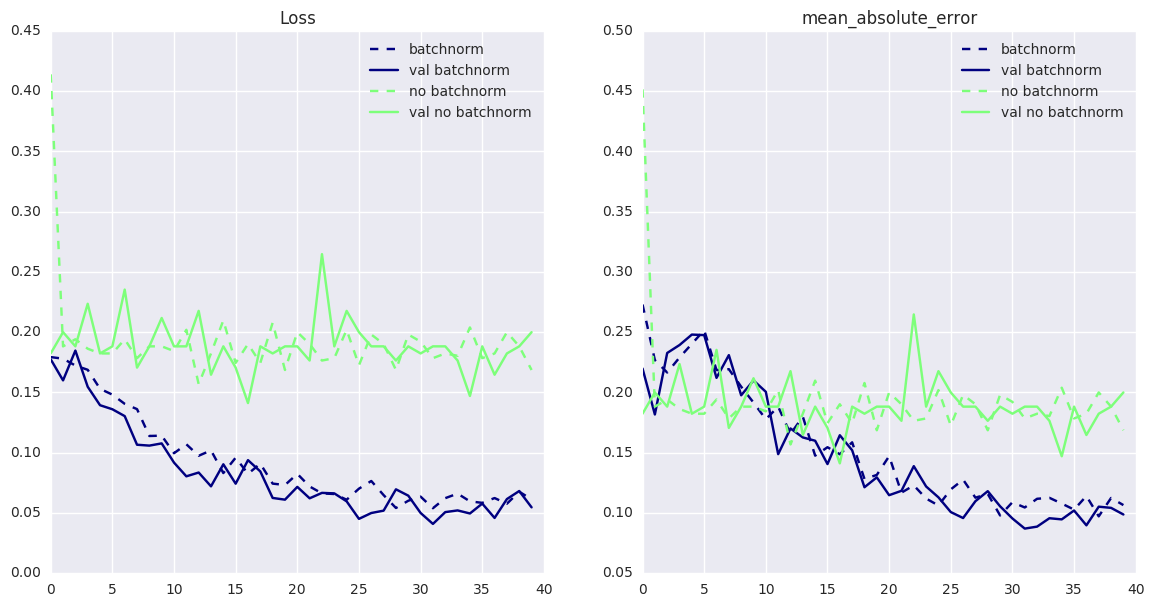

In [27]:
plot_hists(bn_hists)

# Dropout ratio

In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)

models = collections.OrderedDict([
        ('0.1', create_model(base_output_layer=4, train_all=False, batchnorm=True, dropout=0.1)),
        ('0.25', create_model(base_output_layer=4, train_all=False, batchnorm=True, dropout=0.25)),
        ('0.5',  create_model(base_output_layer=4, train_all=False, batchnorm=True, dropout=0.5)),
        ('0.75', create_model(base_output_layer=4, train_all=False, batchnorm=True, dropout=0.75)),
        ('0.9', create_model(base_output_layer=4, train_all=False, batchnorm=True, dropout=0.9)),
    ])
dropout_hists = train_for_all_models(models, nb_epoch=40,
                             train_generator=train_generator, train_dev_generator=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0])

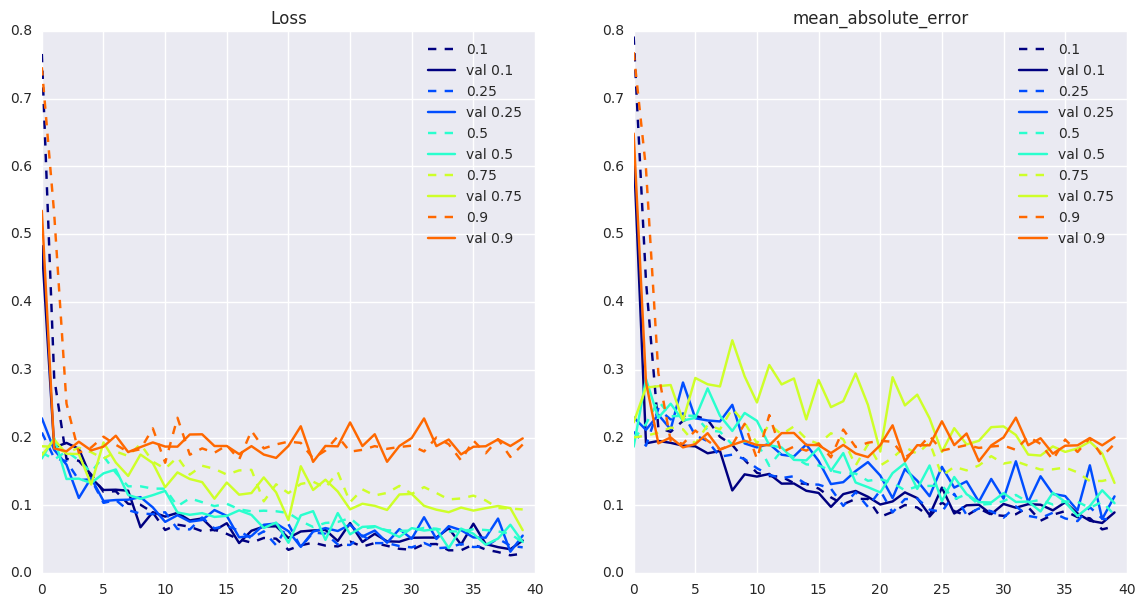

In [28]:
plot_hists(dropout_hists)

# Trainall - with/without


In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)

models = collections.OrderedDict([
        ('train_all', create_model(base_output_layer=4, train_all=True, batchnorm=True)),
        ('train_delta',  create_model(base_output_layer=4, train_all=False, batchnorm=True)),
    ])
trainall_hists = train_for_all_models(models, nb_epoch=40,
                             train_generator=train_generator, train_dev_generator=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0])

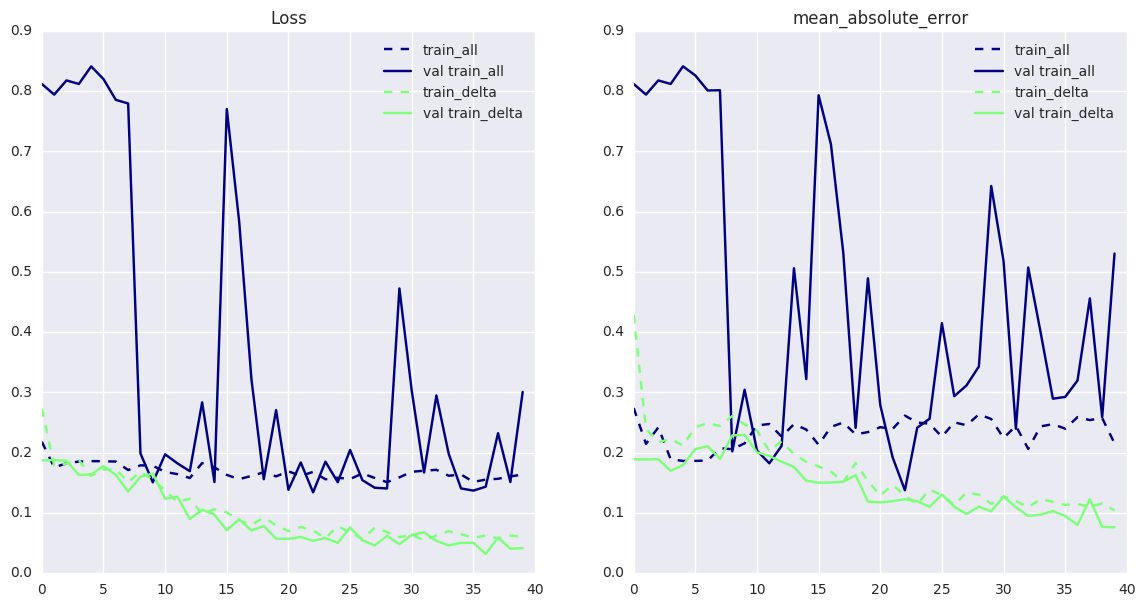

In [29]:
plot_hists(trainall_hists)

# Single vs. Double Batchnorm and Dropout ratios
* single bn, no dropout
* double bn, no dropout
* single bn, 25% dropout
* double bn, 25% dropout

In [ ]:
train_generator = random_background_generator(data.train.X, data.train.y, bg_imgs)
train_dev_generator = random_background_generator(data.train_dev.X, data.train_dev.y, bg_imgs)

models = collections.OrderedDict([
        ('bn_0.0', create_model(base_output_layer=4, train_all=False, batchnorm=True, batchnorm2=False, dropout=0.0)),
        ('2bn_0.0', create_model(base_output_layer=4, train_all=False, batchnorm=True, batchnorm2=True, dropout=0.0)),
        ('bn_0.25', create_model(base_output_layer=4, train_all=False, batchnorm=True, batchnorm2=False, dropout=0.25)),
        ('2bn_0.25', create_model(base_output_layer=4, train_all=False, batchnorm=True, batchnorm2=True, dropout=0.25)),
    ])
comparing_hists = train_for_all_models(models, nb_epoch=40,
                             train_generator=train_generator, train_dev_generator=train_dev_generator, nb_val_samples=data.train_dev.X.shape[0])

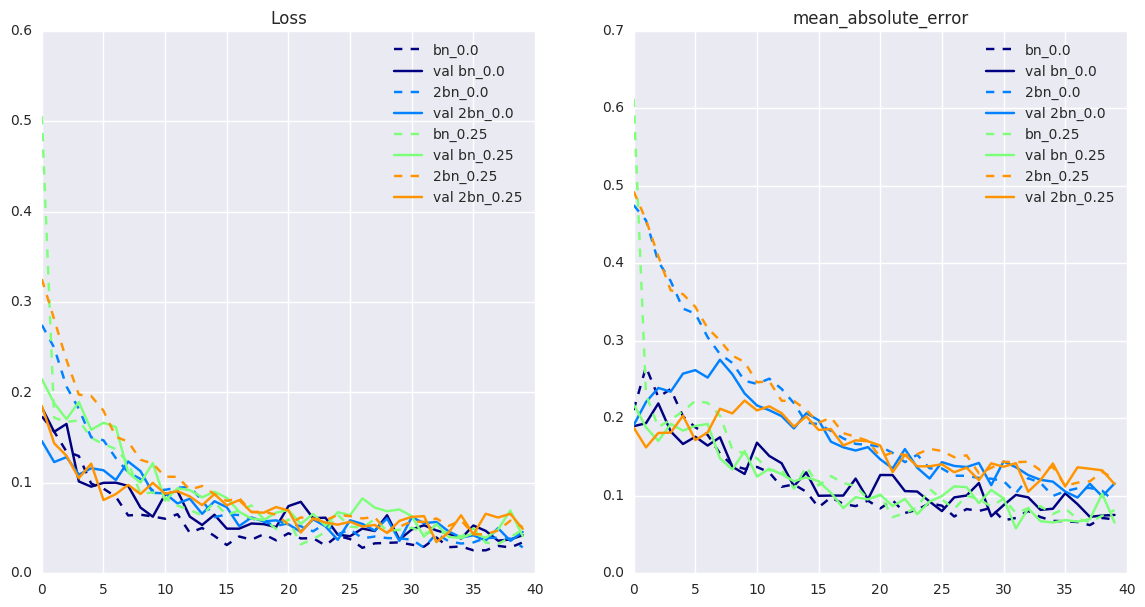

In [35]:
plot_hists(comparing_hists)

In [207]:
data.show()

train
  - X: (545, 100, 100, 3)
  - y: (545, 1)
train_dev
  - X: (182, 100, 100, 3)
  - y: (182, 1)
dev
  - X: (50, 100, 200, 3)
  - y: (50,)
test
  - X: (50, 100, 200, 3)
  - y: (50,)


# Show detectors output gradients on the input

In [ ]:
sns.set_style("white")
i = data.dev.X[13][None,:]

print("\n".join([ "#{} - {:.3f} , {:.3f}".format(ind, act,w) for ind, (act,w) in 
enumerate(np.column_stack((
    K.function([model.input,K.learning_phase()],[model.get_layer('detectors').output])([i,False])[0].T,
    model.get_layer('output').get_weights()[0]
)))
]))

plt.figure(figsize=(20,20))
for det_ind in range(16):
    detectors_output = model.get_layer('detectors').output[:,det_ind]
    grad_on_input = K.gradients([detectors_output], [model.input])[0]
    f = K.function([model.input, K.learning_phase()], [grad_on_input])
    g = f([i-VGG_MEANS, False])[0]
    
    plt.subplot(4,4,det_ind+1)
    plt.imshow(i[0])
    plt.imshow(g[0].mean(axis=2), cmap='bwr', vmin=-1.0, vmax=1.0, alpha=0.75)

# Look at Specific Detectors

In [190]:
model = models['model']
model.get_layer('output').get_weights()

[array([[-0.18133956],
        [ 0.01443466],
        [-0.32900754],
        [ 0.20895897],
        [ 0.17481892],
        [ 0.15342732],
        [ 0.37520447],
        [-0.23177184],
        [-0.17950304],
        [ 0.14417788],
        [-0.12995209],
        [ 0.17849168],
        [ 0.10917401],
        [ 0.08785662],
        [ 0.14813615],
        [ 0.23422906]], dtype=float32), array([-0.17533438], dtype=float32)]

In [116]:
def occluding_analysis(img, patch=(5,5), stride=3, neuron=None):
    neuron_act = K.function([model.input, K.learning_phase()], [neuron])
    original_act = neuron_act([img[None,:], False])[0][0]  # assumes single img for input
    
    ys = range(0,img.shape[0],stride)
    xs = range(0,img.shape[1],stride)
    occ_imgs = np.repeat(img[None,:], 1+len(xs)*len(ys), axis=0)
    occ_imgs[0] = img
    for ind_i, i in enumerate(ys):
        for ind_j, j in enumerate(xs):
            occ_imgs[ind_i*len(xs)+ind_j, i:i+patch[0], j:j+patch[1], :] = VGG_MEANS

    occ_acts = neuron_act([occ_imgs, False])[0]
    occ_diffs_pct = (occ_acts - original_act)/original_act
    
    res = np.empty((len(xs)*len(ys),) + img.shape[:2])
    res[:] = np.NAN
    for ind_i, i in enumerate(ys):
        for ind_j, j in enumerate(xs):
            ind = ind_i*len(xs)+ind_j
            res[ind, i:i+patch[0], j:j+patch[1]] = occ_diffs_pct[ind] 
    
    res = np.nanmean(res, axis=0)
    
    return res

In [117]:
detector = lambda det_id: model.get_layer('detectors').output[:,det_id]

In [ ]:
detector_id = -1
inps = train_dev_sample_imgs[[17]]


num_inps = inps.shape[0]
fig = plt.figure(figsize=(20,10 * num_inps))
gs = gridspec.GridSpec(num_inps,2)

for idx, inp in enumerate(inps):
    print("calcualting occlusion analysis for image ", idx)
    res = occluding_analysis(inp, patch=(10,10), stride=5, neuron=detector(detector_id))
    #print(res.min(), res.mean(), res.max())
    
    ax = plt.Subplot(fig, gs[idx, 0])
    ax.imshow(inp.squeeze())
    im = ax.imshow(res, interpolation='bicubic', cmap=plt.cm.jet_r, alpha=0.5)
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, gs[idx, 1])
    ax.imshow(inp.squeeze())
    fig.add_subplot(ax)

fig.tight_layout()
fig.colorbar(im)

calcualting occlusion analysis for image  0


# Plotting all detectors for a specific image

In [246]:
img = sample_imgs[[0]]
detectors_act = K.function([model.input, K.learning_phase()], [model.get_layer('detectors').output])

In [252]:
print(detectors_act([img, False]))
img2 = img.copy()
img2[0,50:80,50:80,:] = VGG_MEANS
print(detectors_act([img2, False]))

[array([[  3.1919477 ,   3.91502309,  10.94757366,  11.1382618 ,
          3.17056274,   5.37478161,  10.18570423,   3.15120482,
          4.89426184,   4.41453505,   3.3703475 ,   3.67164636,
          2.00529885,   3.74286032,   3.45382881,   5.40113688]], dtype=float32)]
[array([[  3.20147252,   3.96744704,  10.31510639,  10.83223057,
          1.27469826,   5.54047155,   8.78905296,   2.54749632,
          3.00285172,   4.47744131,   3.07102084,   3.6764462 ,
          2.25386977,   3.59055448,   3.35423446,   5.41323709]], dtype=float32)]


In [ ]:
plt.plot(detectors_act([img, False])[0].flatten(), label='orig')
plt.plot(detectors_act([img2, False])[0].flatten(), label='occluded')
plt.legend()

In [199]:
img.min(), img.mean(), img.max()

(-123.68000030517578, -114.1485747273763, -102.93900299072266)

In [119]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
model_15 (Model)                 (None, None, None, 51 7635264     input[0][0]                      
____________________________________________________________________________________________________
bn (BatchNormalization)          (None, None, None, 51 2048        model_15[1][0]                   
____________________________________________________________________________________________________
dropout (Dropout)                (None, None, None, 51 0           bn[0][0]                         
___________________________________________________________________________________________

In [ ]:
x,y = next(train_dev_generator)
y_pred = model.predict(x)
t = list(zip([ "{:.2f}".format(x) for x in y.flatten().tolist() ], [ "{:.2f}".format(x) for x in y_pred.flatten().tolist() ]))
gridplot(x, titles=t)

# Show best activation for neurons

In [122]:
def get_layer_desc(layer):
    if isinstance(layer, keras.layers.Flatten):
        return ""
    elif isinstance(layer, keras.layers.Dense):
        return ""
    elif isinstance(layer, keras.layers.Convolution2D):
        return "{}x({},{})".format(layer.nb_filter, layer.nb_row, layer.nb_col)
    elif isinstance(layer, keras.layers.MaxPooling2D):
        return layer.pool_size
    elif isinstance(layer, keras.layers.normalization.BatchNormalization):
        return "BatchNormalization"
        

def analyze_layer(model, layer_num, trainingset=None, calculate_repr_inputs=True, learning_elements=None, l2_regularizer=0.01, lr=0.5):
    model_input_shape = model.input_shape[1:]
    if type(layer_num) == int:
        layer = model.layers[layer_num]
    else:
        layer = model.get_layer(layer_num)
            
    layer_name = type(layer).__name__
    print("analyzing layer {}...".format(layer_name))
    
    l_input_shape = layer.input.get_shape()
    l_output_shape = layer.output.get_shape()
    
    res = dict( 
        name=layer_name, 
        desc=get_layer_desc(layer),
        input_shape=l_input_shape,
        output_shape=l_output_shape
    )
    
#    w = layer.get_weights()
    if True: #type(layer) in [keras.layers.Dense, keras.layers.Convolution2D]: 
        #l_w, l_b = w
        #num_elements = l_b.shape[0]
        #element_shape = l_w.shape[:len(l_w.shape)-1]
        num_elements = layer.output_shape[-1]

        res['num_learning_elements'] = num_elements
        #res['learning_element_shape'] = element_shape
        
        input_img = model.layers[0].input
    
        # Calculating the representative inputs
        if calculate_repr_inputs:
            repr_inputs = np.zeros((num_elements, ) + model_input_shape)
            rng = learning_elements if learning_elements else range(num_elements)
            for element_id in rng:
                print("element {}".format(element_id))
                # NOTICE: repr element is neuron (0,0) in the conv act map. 
                repr_element_id = [0]*(len(l_output_shape)-1) + [element_id]

                input_shape = (1,)+model_input_shape
                curr_input = np.zeros(input_shape)
                #curr_input += np.random.random(input_shape) * 0.1

                filter_act = layer.output[repr_element_id] - l2_regularizer*K.sum(input_img)
                grads = K.gradients(filter_act, input_img)[0] 
                grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
                it = K.function([input_img, K.learning_phase()], [filter_act, grads])

                learning_rate = lr
                num_iters = 100
                if it([curr_input, False])[0] == 0:
                    curr_input = np.random.random(input_shape)

                for i in range(num_iters):
                    print(".", end="")
                    curr_act, curr_grads = it([curr_input, False])
                    curr_input += learning_rate * curr_grads
                    curr_input = curr_input.clip(-2,2)
                    learning_rate *= 0.98
                print("")
                repr_inputs[element_id,:] = curr_input

            res['learning_elements_repr_inputs'] = repr_inputs

        if trainingset is not None:
#             # Calculating average neuron effect on the final output
#             d_output_layer_output_func = K.function([model.layers[0].input, K.learning_phase()], [K.gradients(model.output, layer.output)[0]])
#             d_output_layer_output = d_output_layer_output_func([trainingset, False])[0]
#             res['grads_on_output'] = d_output_layer_output.mean(axis=tuple(range(len(l_output_shape)-1)))

            # Average Activation Map
            act_map = K.function([model.layers[0].input, K.learning_phase()], [layer.output])
            res['activation_map'] = act_map([trainingset, False])[0].mean(axis=0)
            
        
    return res

In [75]:
def display_analyzed_layer(anl_layer, learning_elements=None, num_cols=8, display_limit=-1):
    print("{} {}".format(anl_layer['name'], anl_layer['desc']))
    print("Input: {}".format(anl_layer['input_shape']))
    print("Output: {}".format(anl_layer['output_shape']))


    #TODO: FIX THIS
    X_train_std = data.train.X.std()
    X_train_means = data.train.X.mean()
    
    if 'num_learning_elements' in anl_layer:

        if not learning_elements: learning_elements = range(anl_layer['num_learning_elements'])
        num_ri = len(learning_elements)

        #fig = plt.figure(figsize=(50,50*num_cols/int(math.ceil(num_ri/num_cols))))
        fig = plt.figure(figsize=(10,100))
        gs = gridspec.GridSpec(int(math.ceil(num_ri/num_cols)), num_cols, wspace=0.0, hspace=0.05)

        inner_gs = [ gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i], wspace=0.0, hspace=0.05) for i in range(num_ri) ]

        for idx, i in enumerate(learning_elements):
            if 'learning_elements_repr_inputs' in anl_layer:
                repr_inputs = anl_layer['learning_elements_repr_inputs']
                inp = repr_inputs[i,:].squeeze()
                # TODO: FIX THIS
                inp = (inp * X_train_std ) + X_train_means
                inp = (inp - inp.min()) / (inp.max() - inp.min())

                img = inp[:display_limit,:display_limit]

                ri_ax = plt.Subplot(fig, inner_gs[idx][0])
                ri_ax.set_title("Activating Input #{}".format(i))
                ri_ax.set_xticks([])
                ri_ax.set_yticks([])
                ri_ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
                fig.add_subplot(ri_ax)
                
                img = img.mean(axis=2)
                ri_ax = plt.Subplot(fig, inner_gs[idx][1])
                ri_ax.set_xticks([])
                ri_ax.set_yticks([])
                ri_ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
                fig.add_subplot(ri_ax)
                

                
            if 'activation_map' in anl_layer:
                actmap = np.moveaxis(anl_layer['activation_map'],-1,0)[i]
                if len(actmap.shape) == 0: continue
                
                act_ax = plt.Subplot(fig, inner_gs[idx][2])
                act_ax.imshow(actmap, cmap=plt.cm.gray, interpolation='nearest')
                act_ax.set_xticks([])
                act_ax.set_yticks([])
                fig.add_subplot(act_ax)
        plt.show()

In [42]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 100, 100, 64)  1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 100, 100, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 50, 50, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [61]:
al = analyze_layer(model, 'detectors', learning_elements=[12], trainingset=data.train.X, lr=0.01, l2_regularizer=0.0001)

analyzing layer GlobalMaxPooling2D...
element 12
....................................................................................................


In [ ]:
X_train_std = 1
X_train_means = 1
display_analyzed_layer(al, learning_elements=[12], num_cols=2)

# Save Model

In [63]:
model.save("model.h5")